In [1]:
from svg.path import parse_path # requires svg.path: pip install svg.path
from svg.path.path import Line
from xml.dom import minidom
from PyPDF2 import PdfFileReader # requires PyPDF2: pip install PyPDF2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
import os, sys
import os.path
import subprocess
from skfda import FDataGrid
import sklearn
from itertools import combinations
from skfda.ml.clustering import KMeans, AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
import time
import math
import sklearn.cluster as sk
from skfda.preprocessing.dim_reduction.projection import FPCA
import statistics as st
from scipy import stats
import random
from skfda.misc.metrics import l2_distance, TransformationMetric, LpDistance, fisher_rao_distance, linf_distance
import hipoxia_clean_data as cd
import importlib
sys.path.append('dahfi_main/database_ctu-chb/')

from src.data import load_FHR_UC, load_targets, load_features_targets
from src.preprocessing import preprocessing_signals, remove_long_gaps, all_zero_move

In [13]:
'''
    Función que genera un scatter tanto para UC como para FHR
    input:
        represent: toma valores 'both', 'pat', 'nopat' para elegir que tipo de grupo se quiere representar
'''
def scatterThreeDim(scores_fhr,  target, clusters, axislabels = None, leyend = None, save = None, quitleyend = False, scores_uc = None, target2 = None, title = 'Diagrama de puntos', ):
    fig = plt.figure(figsize=plt.figaspect(0.4))

    fig.suptitle(title, fontsize=16)
    
    if scores_uc is not None:
        n_clusters = len(set(target2))
        arr = np.array(target2)
        dict = {}
        labels = {}
        colormap = plt.cm.get_cmap('tab20b')
        cluster_colors = colormap(np.arange(n_clusters) / (n_clusters - 1))

        for i in range(0, n_clusters):
            dict[i] = np.where(arr==i)[0]
            if leyend is not None:
                labels[i] = leyend[i]
            else:
                labels[i] = 'Clúster ' + str(i)

        
        # =============
        # First subplot: UC
        # =============
        # set up the axes for the first plot
        
        
        ax = fig.add_subplot(1, 2, 1, projection='3d')
        
        ax.title.set_text('UC')
        if axislabels:
            ax.set_xlabel(axislabels[0])
            ax.set_ylabel(axislabels[1])
            ax.set_zlabel(axislabels[2])
        else:
            ax.set_xlabel('Primera componente')
            ax.set_ylabel('Segunda componente')
            ax.set_zlabel('Terera componente')

        x, y, z = map(list, zip(*scores_uc))
        for ele in clusters:
            ax.scatter3D(list(map(x.__getitem__, dict[ele])),
                        list(map(y.__getitem__, dict[ele])),
                        list(map(z.__getitem__, dict[ele])),
                        color=cluster_colors[ele], label=labels[ele])

    # ==============
    # Second subplot: FHR
    # ==============
    # set up the axes for the second plot
    # =============
    n_clusters = len(set(target))
    arr = np.array(target)
    dict = {}
    labels = {}
    colormap = plt.cm.get_cmap('tab20b')
    cluster_colors = colormap(np.arange(n_clusters) / (n_clusters - 1))

    for i in range(0, n_clusters):
            dict[i] = np.where(arr==i)[0]
            if leyend is not None:
                labels[i] = leyend[i]
            else:
                labels[i] = 'Clúster ' + str(i)

    if scores_uc is not None:
        ax = fig.add_subplot(1, 2, 2, projection='3d')
    else:
        ax = fig.add_subplot(projection='3d')

    ax.title.set_text('FHR')

    if axislabels:
        ax.set_xlabel(axislabels[0])
        ax.set_ylabel(axislabels[1])
        ax.set_zlabel(axislabels[2])
    else:
        ax.set_xlabel('Primera componente')
        ax.set_ylabel('Segunda componente')
        ax.set_zlabel('Terera componente')

    x, y, z = map(list, zip(*scores_fhr))

    for ele in clusters:
            ax.scatter3D(list(map(x.__getitem__, dict[ele])),
                        list(map(y.__getitem__, dict[ele])),
                        list(map(z.__getitem__, dict[ele])),
                        color=cluster_colors[ele], label=labels[ele])
    if not quitleyend:
        ax.legend(loc='upper right')
    if save:
        plt.savefig("img/scatter/" + save + ".png",dpi=300)
    plt.show()


In [5]:
'''
    Función para guardar datos en un csv
'''
def save_csv(filename, header, data, sort_column=None):
    df = pd.DataFrame(data, columns=header)
    if os.path.isfile(filename):
        df2 = pd.read_csv(filename)
        df = pd.concat([df, df2]).drop_duplicates()
        
    if sort_column:
        df = df.sort_values(by=[sort_column], ascending=False)
    df.to_csv(filename,index=False)

In [6]:
''' 
    Función para generar diagramas de cajas a partir de ciertos datos.
'''
def showBoxPlot(data, xticklables = None, title=None, suptitle = None, save=False, nplots = None):
    # More than one subplot
    if nplots:
        values = []
        fig, ax = plt.subplots(1,nplots)
        for i in range(0, nplots):
            if title is not None:
                ax[i].set_title(title[i])
            val = ax[i].boxplot(data[i])
            values += [val]
            if xticklables is not None:
                ax[i].set_xticks(ax[i].get_xticks())
                ax[i].set_xticklabels(xticklables)
        
        fig.set_size_inches(4*nplots, 4)
        if suptitle:
            fig.suptitle(suptitle , fontsize=16)
    #Just one subplot
    else:
        _, ax = plt.subplots()

        if title:
            ax.set_title(title)
        
        values = ax.boxplot(data)

        if xticklables:
            ax.set_xticks(ax.get_xticks())
            ax.set_xticklabels(xticklables)
        if suptitle:
            fig.suptitle(suptitle , fontsize=16)

    
    if save:
        p = plt.savefig("img/boxplots/" + save + ".png",dpi=300)
        
    plt.show()
    return values


In [7]:
'''
    Función que dado un array, devuelve las posiciones en dicho array de los elementos que coincidan con el deseado
    input:
            preds: array a estudiar
            n_cluster: elemento que buscamos en el array
    output:
            lista de indices en el array
'''
def get_index_of_clusters(preds, n_cluster):
    index = []
    for i in range(0, len(preds)):
        if preds[i] == n_cluster:
            index += [i]
    return index

In [10]:
'''
    Función que itera para aplicar K medias para un rango de número de clústers. Para cada número de clústers genera diagramas de cajas comparando ciertas 
    características de los clústers.

    start: número de clústers con el que empieza 
    stop: número de clústers con los que termina
    data: datos a los que aplicar k medias (formato ya en FDataGrid)
    functional: booleano que toma True si los datos son funcionales, o False si son multivariantes
    save: None si no queremos guardar los resultados, 'Nombre del fichero' en caso afirmativo
    boxplot: es una lista de argumentos, que tendrán valor diferente a None en caso que se quieran realizar los diagramas de cajas
            Tiene la forma [lista de caracteristicas, lista de titulos]
    return: tupla con - valor máximo de precision alcanzada
                      - lista que nos indica que combinación de las predicciones hemos utilizado
                      - Si se alcanza con dicho orden o al revés
'''
def KMeans_iterate (start, stop, data, functional = True, save = False, box_plot = [None,None], metric = LpDistance(p=2, vector_norm=None)):
    
    savings = []
    preds = {}
    
    header = ['Seed', 'Number of clusters']

    for n_clusters in range(start, stop):
        print("Computing for %d clusters" %n_clusters)
        seed = math.floor(time.time())

        if functional:
            kmeans = KMeans(n_clusters=n_clusters, metric = metric, random_state=seed).fit(data)
        else:
            kmeans = sk.KMeans(n_clusters=n_clusters, random_state=seed).fit(data)
            
        pred = kmeans.predict(data)
        preds[n_clusters] = pred
        savings += [[seed, n_clusters]]

        if box_plot[0] is not None:
            #Obtenemos el número de boxplots que realizaremos por cada ejecución de K medias.
            n_subplots = len(box_plot[0])
            if n_subplots > 1:
                boxplot_data = []
                for i in range(0, n_subplots):
                    clusters = {}
                    xlabels = []
                    for j in range(0,n_clusters):
                        # Get indexes of cluster j
                        ind = get_index_of_clusters(preds=list(preds[n_clusters]), n_cluster=j)
                        #Obtain characteristic for that cluster
                        clusters[j] = [list(box_plot[0][i])[ele] for ele in ind]
                        xlabels += ["Cluster "+ str(j)]
                    boxplot_data += [list(clusters.values())]
                showBoxPlot(data= boxplot_data, xticklables = tuple(xlabels), title = box_plot[1], nplots=n_subplots, save = 'boxplot_fd_supremo' + str(seed))  
            else:
                combined = list(map(lambda x,y: [x,y] ,box_plot[0][0], list(preds[n_clusters])))
                clusters = {}
                xlabels = []
                for i in range(0,n_clusters):
                    clusters[i] = list(map(lambda ele: ele[0], filter(lambda n:  n[1] == i,combined)))
                    xlabels += ["Cluster "+ str(i)]
                showBoxPlot(data= list(clusters.values()), xticklables = tuple(xlabels), title = box_plot[1], save = 'bocplot_fd_euclidea' + str(seed), suptitle ="K = "+ str(n_clusters))
            
    if save:
        save_csv(filename = 'seeds.txt', header = header, data=savings, sort_column='Seed')
    return preds, savings

Cargamos las variables con las que trabajaremos

In [2]:
path_csv_features = 'dahfi_main/database_ctu-chb/features/comert_features/'
preprocess_method = 'comert_gaps'
features = pd.read_csv(path_csv_features+preprocess_method+'_features.csv', index_col=0)

X = features[features.columns[0:3].tolist() + features.columns[4:5].tolist()]
mean = np.array(features['mean'])
dcc = np.array(features['DCC'])
acc = np.array(features['ACC'])
std = np.array(features['std'])
baseline = np.array(features['baseline'])

Por facilidad añadimos a nuestros datos la columna del pH, aunque los únicos objetivos de estos son comparativos, nunca para hacer clústering partiendo de dicho valor

In [3]:
clinical_df = pd.read_csv('dahfi_main/database_ctu-chb/data/clinical_ctu-chb.csv', index_col=0, compression='gzip')
pH = clinical_df['ph']
X['pH'] = pH
target = load_targets(pH=7.2, path_csv='dahfi_main/database_ctu-chb/data/')
X['target'] = target

 /home/ejerez/Escritorio/UNI/QUINTO/Matrícula y TFGs/TFG/codigo/venv/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
 /home/ejerez/Escritorio/UNI/QUINTO/Matrícula y TFGs/TFG/codigo/venv/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning:
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Según los criteros FIGO:
|               | Normal                      | Pathological                                                                                                                                                             |
|---------------|-----------------------------|--------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| Baseline      | 110-160 bpm                 | < 100 bpm                                                                                                                                                                |
| Variability | 5-25 bpm                    | Reduced/increased variability or sinusoidal pattern                                                                                                                      |
| Decelerations    | No repetitive decelerations | Repetitive, late or prolonged decelerations during more than 30 minutes (or 20 minutes if reduced variability), or one prolonged deceleration during more than 5 minutes |

Consideraremos por tanto las siguientes variables, que hemos obtenido de la siguiente forma:
- baseline: media de la señal, quitando valores extremos $$|xn - media| <= std(1 + \frac{1}{\sqrt{N}})$$
- std: desviación típica de la señal
- dcc: número de veces que la señal está 15bmp o más por debajo del baseline y durante más de 15s pero menos de 10 minutos

La única modificación que tenemos que hacer es estandarizarlas. Este paso es importante en métodos como K medias que estudian distancias entre vectores. Las diferencias entre las magnitudes de las distintas variables hacen que tengan mayor peso aquellas que alcanzan unos valores más altos. En nuestro caso, no queremos darle mayor peso a ninguna de las variables que estudiamos y por ello las estandarizamos todas.

In [4]:
X_std = stats.zscore(X[['baseline', 'DCC', 'std', 'ACC']])
X_std['pH'] = X['pH']
X_std['target'] = X['target']

En todo el estudio además utilizaremos la distancia euclídea, pues con este tipo de datos es la más adecuada

# K medias

Computing for 2 clusters


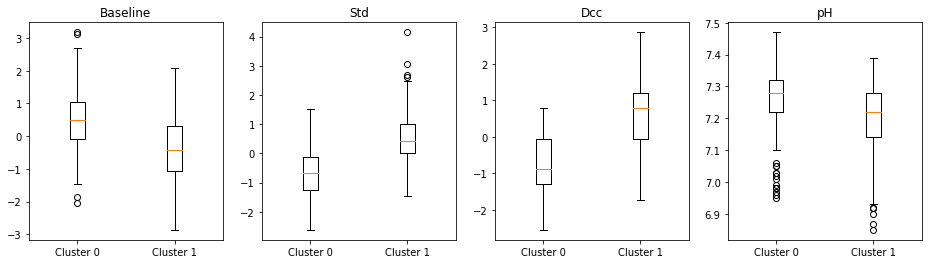

Computing for 3 clusters


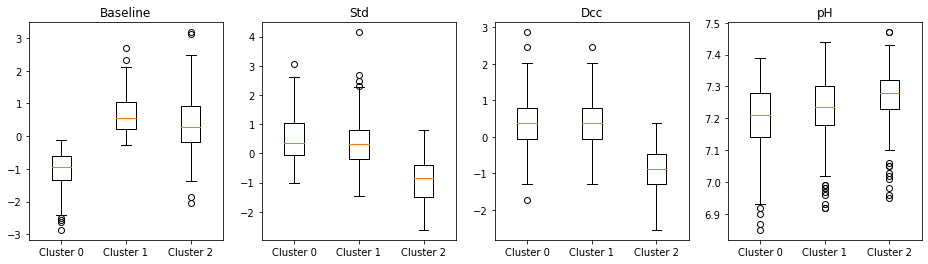

Computing for 4 clusters


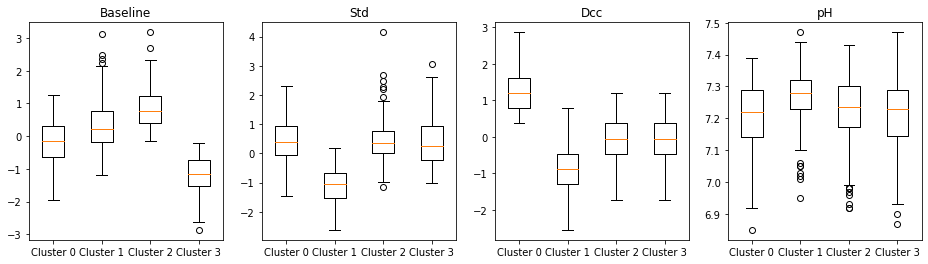

Computing for 5 clusters


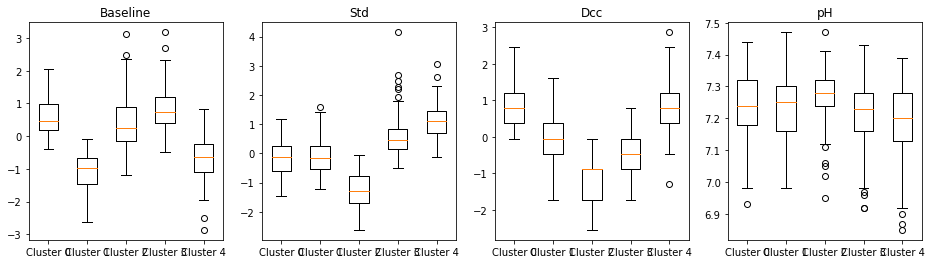

In [11]:
res = KMeans_iterate(2, 6, np.array(X_std[['baseline', 'DCC', 'std']]), functional = False,
    box_plot=[[np.array(X_std['baseline']), np.array(X_std['std']), np.array(X_std['DCC']), np.array(X_std['pH'])],
            ['Baseline', 'Std', 'Dcc', 'pH']])

Podemos observar que en este caso no es tan determinante la agrupación por la media (baseline). Lo que si se puede observar es una correlación entre el diagrama de cajas de la desviación típica, junto a los ded aceleraciones y deceleraciones. Este comportamiento tiene sentido porque justo con la desviación típica medimos la variación o la dispersión de los datos. No son exactamente lo mismo que decelaraciones y aceleraciones, pero se intuye que si se producen muchas de estas últimas, los datos estarán en general más dispersos.

Para comprender mejor los clústers que hemos obtenido podemos intentar pintar algunas observaciones de cada uno de ellos. Para ello creamos una función que nos devuelva una submuestra de cada grupo.

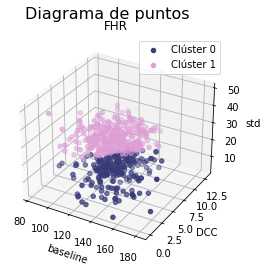

In [14]:
n_cluster = 2
scatterThreeDim(axislabels = ['baseline', 'DCC', 'std'], scores_fhr = np.array(X[['baseline', 'DCC', 'std']]), target = res[0][n_cluster], clusters = [i for i in range(0,n_cluster)])

# Clústering jerárquico

In [16]:
import numpy as np

from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram
from sklearn.datasets import load_iris
from sklearn.cluster import AgglomerativeClustering as ac


def plot_dendrogramm(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)


In [17]:
hier_data = np.array(X_std[['baseline', 'DCC', 'std']])
hier_data.shape

(552, 3)

### SINGLE LINKAGE

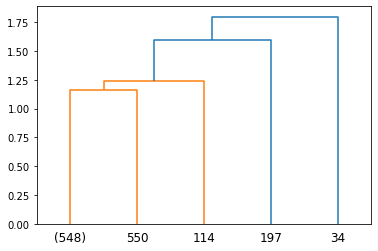

In [18]:
# setting distance_threshold=0 ensures we compute the full tree.
model = ac(distance_threshold=0, 
            n_clusters = None,
            linkage='single')

model = model.fit(hier_data)
# plot the top three levels of the dendrogram
plot_dendrogramm(model, truncate_mode="lastp", p=5)
plt.savefig("img/dendograms/variables.png",dpi=300)
  
plt.show()

### AVERAGE LINKAGE

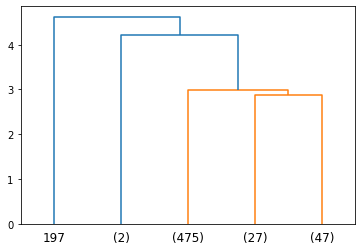

In [20]:
# setting distance_threshold=0 ensures we compute the full tree.
model = ac(distance_threshold=0, 
            n_clusters = None,
            linkage='average')

model = model.fit(hier_data)
# plot the top three levels of the dendrogram
plot_dendrogramm(model, truncate_mode="lastp", p=5)
plt.savefig("img/dendograms/variables.png",dpi=300)
  
plt.show()

### COMPLETE LINKAGE

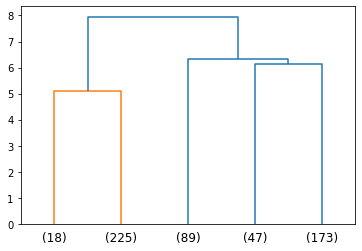

In [21]:
# setting distance_threshold=0 ensures we compute the full tree.
model = ac(distance_threshold=0, 
            n_clusters = None,
            linkage='complete')

model = model.fit(hier_data)
# plot the top three levels of the dendrogram
plot_dendrogramm(model, truncate_mode="lastp", p=5)
plt.savefig("img/dendograms/variables.png",dpi=300)
  
plt.show()

In [22]:
def permutar(valor1, valor2, lista):
    for i in range(0, len(lista)):
        if lista[i] == valor1:
            lista[i] = valor2
        elif lista[i] == valor2:
            lista[i] = valor1
    return lista

Computing for 3 clústers


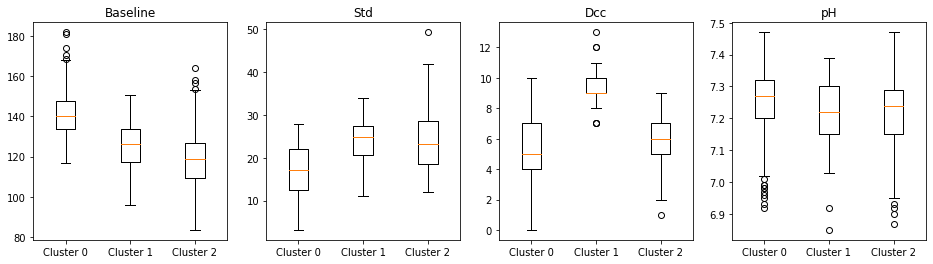

Computing for 4 clústers


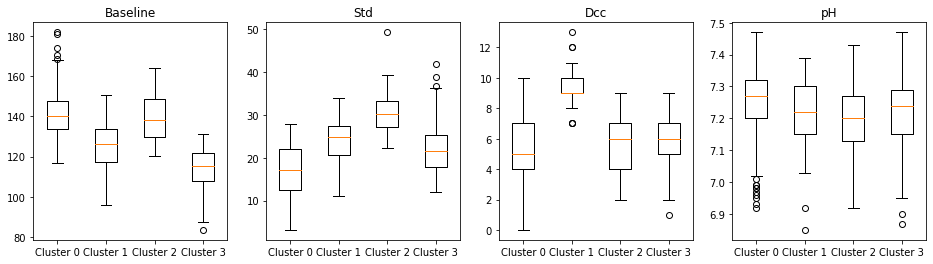

Computing for 5 clústers


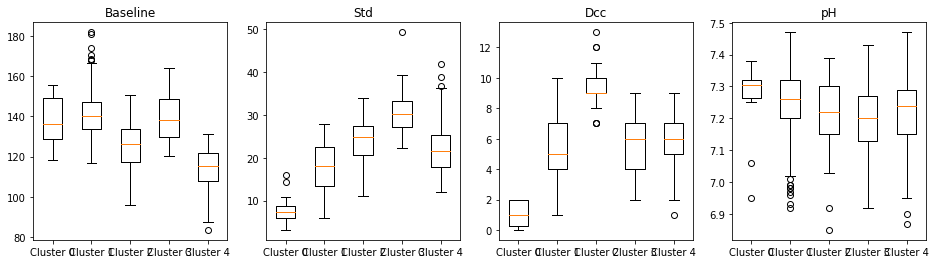

In [28]:
permus = {}
permus[3] = [243, 89, 220]
permus[4] = [243, 89, 47, 173]
permus[5] = [18, 225, 89, 47, 173]
pred = {}

for n_clst in range(3,6):
    clustering = ac(
            n_clusters = n_clst, 
            linkage='complete')
    clustering.fit(hier_data)
    pred[n_clst] = clustering.labels_.astype(np.int_)
    for ele in range(0, len(permus[n_clst])):
        for clus in list(set(pred[n_clst])):
            if list(pred[n_clst]).count(clus) == permus[n_clst][ele]:
                pred[n_clst] = permutar(clus, ele + 10, pred[n_clst])
    for ele in range(0, len(permus[n_clst])):    
        pred[n_clst] = permutar(ele + 10, ele, pred[n_clst])

box_plot = [[baseline, std, dcc, pH], ["Baseline", "Std", "Dcc", "pH"]]
n_subplots = len(box_plot[0])
similitud = 'variables'
boxplot_values = {}
for n_clusters in range(3,6):
    print('Computing for ' + str(n_clusters) + ' clústers')
    boxplot_data = []
    for i in range(0, n_subplots):
        clusters = {}
        xlabels = []
        for j in range(0,n_clusters):
            # Get indexes of cluster j
            ind = get_index_of_clusters(preds=list(pred[n_clusters]), n_cluster=j)
            #Obtain characteristic for that cluster
            clusters[j] = [list(box_plot[0][i])[ele] for ele in ind]
            xlabels += ["Cluster "+ str(j)]
        boxplot_data += [list(clusters.values())]
    res = showBoxPlot(data= boxplot_data, xticklables = tuple(xlabels), title = box_plot[1], nplots=n_subplots, save = similitud+str(n_clusters))
    boxplot_values[n_clusters] = res
            